# **Introduction to Segger**

Segger is a cutting-edge cell segmentation model specifically designed for **single-molecule resolved spatial omics** datasets. It addresses the challenge of accurately segmenting individual cells in complex imaging datasets, leveraging a unique approach based on graph neural networks (GNNs).

The core idea behind Segger is to model both **nuclei** and **transcripts** as graph nodes, with edges connecting them based on their spatial proximity. This allows the model to learn from the co-occurrence of nucleic and cytoplasmic molecules, resulting in more refined and accurate cell boundaries. By using spatial information and GNNs, Segger achieves state-of-the-art performance in segmenting single cells in datasets such as 10X Xenium and MERSCOPE, outperforming traditional methods like Baysor and Cellpose.

Segger's workflow consists of:
1. **Dataset creation**: Converting raw transcriptomic data into a graph-based dataset.
2. **Training**: Training the Segger model on the graph to learn cell boundaries.
3. **Prediction**: Using the trained model to make predictions on new datasets.

This tutorial will guide you through each step of the process, ensuring you can train and apply Segger for your own data.

Installing segger from the GitHub repository:

In [ ]:
!git clone https://github.com/EliHei2/segger_dev.git
%cd segger_dev
!pip install ".[rapids12]" -q

Downloading the [Xenium Human Pancreatic Dataset](https://www.10xgenomics.com/products/xenium-human-pancreatic-dataset-explorer):

In [ ]:
!mkdir data_xenium
%cd data_xenium
!wget https://cf.10xgenomics.com/samples/xenium/1.6.0/Xenium_V1_hPancreas_Cancer_Add_on_FFPE/Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs.zip
!unzip Xenium_V1_hPancreas_Cancer_Add_on_FFPE_outs.zip
%cd ..

In [ ]:
from segger.data.io import XeniumSample
from segger.training.segger_data_module import SeggerDataModule
from segger.training.train import LitSegger
from segger.prediction.predict import predict, load_model
from segger.data.utils import calculate_gene_celltype_abundance_embedding
from lightning.pytorch.loggers import CSVLogger
from pytorch_lightning import Trainer
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scanpy as sc

# **1. Create your Segger Dataset**

In this step, we generate the dataset required for Segger's cell segmentation tasks.

Segger relies on spatial transcriptomics data, combining **nuclei** and **transcripts** from single-cell resolved imaging datasets. These nuclei and transcript nodes are represented in a graph, and the spatial proximity of transcripts to nuclei is used to establish edges between them.

To use Segger with a Xenium dataset, you need the **`transcripts.csv.gz`** and **`nucleus_boundaries.csv.gz`** files. The **transcripts** file contains spatial coordinates and information for each transcript, while the **nucleus boundaries** file defines the polygon boundaries of the nuclei. These files enable Segger to map transcripts to their respective nuclei and perform cell segmentation based on spatial relationships. Segger can also be extended to other platforms by modifying the column names or formats in the input files to match its expected structure, making it adaptable for various spatial transcriptomics technologies.

To create the dataset, you need to specify the path to the **transcripts** file and the **nuclei boundaries** file. These are typically downloaded from a spatial transcriptomics dataset like the [Xenium Human Pancreatic Dataset](https://www.10xgenomics.com/products/xenium-human-pancreatic-dataset-explorer).

- **`--transcripts_path`**: Path to the transcripts file, which contains single-cell transcriptomic data.
- **`--boundaries_path`**: Path to the boundaries file, most often representing the nuclei boundaries in the imaging dataset.

If single cell RNA sequencing results are available, you can incorporate them as features for segger:

In [ ]:
# scrnaseq_file = Path('my_scRNAseq_file.h5ad')
# celltype_column = 'celltype_column'
# gene_celltype_abundance_embedding = calculate_gene_celltype_abundance_embedding(
#     sc.read(scrnaseq_file),
#     celltype_column
# )

In [7]:
# Paths to Xenium sample data and where to store Segger data
xenium_data_dir = Path('data_xenium')
segger_data_dir = Path('data_segger')

# Setup Xenium sample to create dataset
xs = XeniumSample(
    verbose=False,
    # embedding_df=gene_celltype_abundance_embedding # uncomment if gene-celltype embeddings are available
)
xs.set_file_paths(
    transcripts_path=xenium_data_dir / 'transcripts.parquet',
    boundaries_path=xenium_data_dir / 'nucleus_boundaries.parquet',
)
xs.set_metadata()

The following parameters are used to build a tiled Segger dataset:

- **`--processed_dir`**: Directory where the processed dataset will be saved.
- **`--x_size`, `--y_size`**: These parameters specify the size of the tiles used to divide the image. The size of the tiles determines how the spatial region is partitioned for processing.
- **`--d_x`, `--d_y`**: These define the step size of the spatial grid used to bin transcripts and nuclei into tiles.
- **`--r_tx`**: Specifies the radius used for graph construction. A smaller radius will connect transcripts to nearby nuclei, while a larger radius might connect them to more distant neighbors.
- **`--scale_boundaries`**: The factor by which to scale the boundary polygons. Suggested to keep `=1` when boundaries refer to nuclei.
- **`--k_tx`**: Defines the number of nearest neighbors considered when building graphs for transcripts (`k_tx`).
- **`--val_prob` and `--test_prob`**: These control the proportion of the dataset that will be set aside for validation and testing. For instance, `--val_prob 0.1` means 10% of the data will be used for validation.
- **`--compute_labels`**: When set to `True`, this flag triggers the computation of labels (cell assignments) for each transcript. Use False if you just plan to perform prediction using a pre-existing model.

Once the dataset is processed, the output will be ready for training the Segger model.


In [ ]:
try:
    xs.save_dataset_for_segger(
        processed_dir=segger_data_dir,
        r_tx=5,
        k_tx=15,
        x_size=120,
        y_size=120,
        d_x=100,
        d_y=100,
        margin_x=10,
        margin_y=10,
        scale_boundaries=1,
        num_workers=4,  # change to your number of CPUs
    )
except AssertionError as err:
    print(f'Dataset already exists at {segger_data_dir}')

### **1.2 Faster Dataset Creation with Segger**

Segger introduces a faster, more efficient pipeline for processing spatial transcriptomics data. This method accelerates dataset creation, particularly for large datasets, by using **ND-tree-based spatial partitioning** and **parallel processing**. This results in a much faster preparation of the dataset, which is saved in PyTorch Geometric (PyG) format, similar to the previous method.

**Note**: The previous dataset creation method will soon be deprecated in favor of this optimized pipeline.

#### **Requirements for the Faster Pipeline**
The pipeline requires the following inputs:

- **base_dir**: The directory containing the raw dataset.
- **data_dir**: The directory where the processed dataset (tiles in PyG format) will be saved.

The core improvements in this method come from the use of **ND-tree partitioning**, which splits the data efficiently into spatial regions, and **parallel processing**, which speeds up the handling of these regions across multiple CPU cores. For example, using this pipeline, the Xenium Human Pancreatic Dataset can be processed in just a few minutes when running with 16 workers.

#### **Running the Faster Dataset Creation Pipeline**
Below is an example of how to create a dataset using the faster Segger pipeline:

In [10]:
from segger.data.parquet.sample import STSampleParquet

In [ ]:
xenium_data_dir = Path('data_xenium')
segger_data_dir = Path('data_segger')

sample = STSampleParquet(
    base_dir=xenium_data_dir,
    n_workers=4,
    sample_type='xenium',
    # weights=gene_celltype_abundance_embedding, # uncomment if gene-celltype embeddings are available
)

sample.save(
      data_dir=segger_data_dir,
      k_bd=3,
      dist_bd=15.0,
      k_tx=3,
      dist_tx=5.0,
      tile_width=120,
      tile_height=120,
      neg_sampling_ratio=5.0,
      frac=1.0,
      val_prob=0.1,
      test_prob=0.2,
)

#### **Parameters**
Here is a complete list of parameters you can use to control the dataset creation process:

- **--base_dir**: Directory containing the raw spatial transcriptomics dataset.
- **--data_dir**: Directory where the processed Segger dataset (in PyG format) will be saved.
- **--sample_type**: (Optional) Specifies the type of dataset (e.g., "xenium" or "merscope"). Defaults to None.
- **--scrnaseq_file**: Path to the scRNAseq file (default: None).
- **--celltype_column**: Column name for cell type annotations in the scRNAseq file (default: None).
- **--k_bd**: Number of nearest neighbors for boundary nodes (default: 3).
- **--dist_bd**: Maximum distance for boundary neighbors (default: 15.0).
- **--k_tx**: Number of nearest neighbors for transcript nodes (default: 3).
- **--dist_tx**: Maximum distance for transcript neighbors (default: 5.0).
- **--tile_size**: Specifies the size of the tile. If provided, it overrides both tile_width and tile_height.
- **--tile_width**: Width of the tiles in pixels (ignored if tile_size is provided).
- **--tile_height**: Height of the tiles in pixels (ignored if tile_size is provided).
- **--neg_sampling_ratio**: Ratio of negative samples (default: 5.0).
- **--frac**: Fraction of the dataset to process (default: 1.0).
- **--val_prob**: Proportion of data used for validation split (default: 0.1).
- **--test_prob**: Proportion of data used for testing split (default: 0.2).
- **--n_workers**: Number of workers for parallel processing (default: 1).

# **2. Train your Segger Model**

The Segger model training process begins after the dataset has been created. This model is a **heterogeneous graph neural network (GNN)** designed to segment single cells by leveraging both nuclei and transcript data.

Segger uses graph attention layers to propagate information across nodes (nuclei and transcripts) and refine cell boundaries. The model architecture includes initial embedding layers, attention-based graph convolutions, and residual connections for stable learning.

Segger leverages the **PyTorch Lightning** framework to streamline the training and evaluation of its graph neural network (GNN). PyTorch Lightning simplifies the training process by abstracting away much of the boilerplate code, allowing users to focus on model development and experimentation. It also supports multi-GPU training, mixed-precision, and efficient scaling, making it an ideal framework for training complex models like Segger.


Key parameters for training:
- **`--data_dir`**: Directory containing the training data.
- **`--model_dir`**: Directory in which to store models.
- **`--epochs`**: Specifies the number of training epochs.
- **`--batch_size`**: Batch sizes for training and validation data.
- **`--learning_rate`**: The initial learning rate for the optimizer.
- **`--hidden_channels`**: Number of hidden channels in the GNN layers.
- **`--heads`**: Number of attention heads used in each graph convolutional layer.
- **`--init_emb`**: Sets the dimensionality of the initial embeddings applied to the input node features (e.g., transcripts). A higher embedding dimension may capture more feature complexity but also requires more computation.
- **`--out_channels`**: Specifies the number of output channels after the final graph attention layer, e.g. the final learned representations of the graph nodes.

Additional Options for Training the Segger Model:

- **`--aggr`**: This option controls the aggregation method used in the graph convolution layers.
- **`--accelerator`**: Controls the hardware used for training, such as `cuda` for GPU training. This enables Segger to leverage GPU resources for faster training, especially useful for large datasets.
- **`--strategy`**: Defines the distributed training strategy, with `auto` allowing PyTorch Lightning to automatically configure the best strategy based on the hardware setup.
- **`--precision`**: Enables mixed precision training (e.g., `16-mixed`), which can speed up training and reduce memory usage while maintaining accuracy.

In [ ]:
# Base directory to store Pytorch Lightning models
models_dir = Path('models')

# Initialize the Lightning model
metadata = (["tx", "bd"], [("tx", "belongs", "bd"), ("tx", "neighbors", "tx")])
ls = LitSegger(
    num_tx_tokens=500,
    init_emb=8,
    hidden_channels=32,
    out_channels=8,
    heads=2,
    num_mid_layers=2,
    aggr='sum',
    metadata=metadata,
)

# Initialize the Lightning data module
dm = SeggerDataModule(
    data_dir=segger_data_dir,
    batch_size=2,
    num_workers=2,
)

dm.setup()


# if you wish to use more than 1 device for training you should run this:
batch = dm.train[0]
ls.forward(batch)

# Initialize the Lightning trainer
trainer = Trainer(
    accelerator='cuda',
    strategy='auto',
    precision='16-mixed',
    devices=1,
    max_epochs=100,
    default_root_dir=models_dir,
    logger=CSVLogger(models_dir),
)

In [ ]:
# Fit model
trainer.fit(
    model=ls,
    datamodule=dm
)

### *Troubleshooting #1*

In the cell below, we are visualizing key metrics from the model training and validation process. The plot displays **training loss**, **validation loss**, **F1 validation score**, and **AUROC validation score** over training steps. We expect to see the loss curves decreasing over time, signaling the model's improvement, and the F1 and AUROC scores increasing, reflecting improved segmentation performance as the model learns.

If training is not working effectively, you might observe the following in the plot displaying **training loss**, **validation loss**, **F1 score**, and **AUROC**:

- **Training loss not decreasing**: If the training loss remains high or fluctuates without a consistent downward trend, this indicates that the model is not learning effectively from the training data.
- **Validation loss decreases, then increases**: If validation loss decreases initially but starts to increase while training loss continues to drop, this could be a sign of **overfitting**, where the model is performing well on the training data but not generalizing to the validation data.
- **F1 score and AUROC not improving**: If these metrics remain flat or show inconsistent improvement, the model may be struggling to correctly segment cells or classify transcripts, indicating an issue with learning performance.


Text(0.5, 0, 'Step')

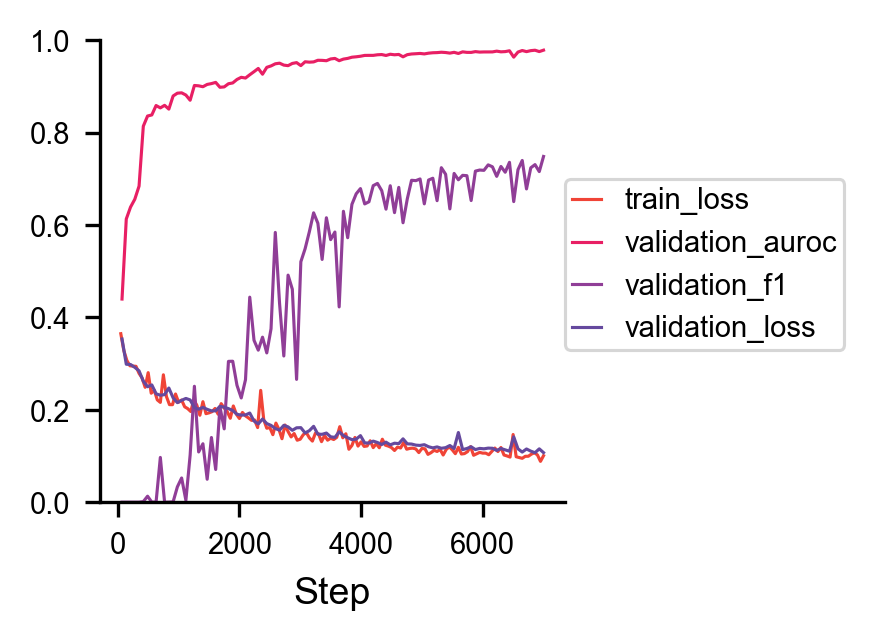

In [ ]:
# Evaluate results
model_version = 0  # 'v_num' from training output above
model_path = models_dir / 'lightning_logs' / f'version_{model_version}'
metrics = pd.read_csv(model_path / 'metrics.csv', index_col=1)

fig, ax = plt.subplots(1,1, figsize=(2,2))

for col in metrics.columns.difference(['epoch']):
    metric = metrics[col].dropna()
    ax.plot(metric.index, metric.values, label=col)

ax.legend(loc=(1, 0.33))
ax.set_ylim(0, 1)
ax.set_xlabel('Step')

# **3. Make Predictions**

Once the Segger model is trained, it can be used to make predictions on seen or unseen data. This step involves using a trained checkpoint to predict cell boundaries and refine transcript-nuclei associations.

Key parameters for making predictions:
- **`--checkpoint_path`**: Path to the trained model checkpoint, which stores the learned weights.
- **`--batch_size`**: Batch size used during inference.
- **`--score_cut`**: Defines the score threshold for classifying predictions. Higher values of `score_cut` make the model more conservative in associating transcripts with nuclei.
- **`--receptive_field`**: These parameters once again define the nearest neighbors for nuclei (`k_bd`) and transcripts (`k_tx`) and their distances (`dist_bd` and `dist_tx`) during the prediction stage.
- **`--use_cc`**: Used when some **transcripts are not directly associated with any nucleus**—a common scenario when a nucleus isn't captured on the slide or within the field of view. In these cases, Segger uses **connected components (CC)** to group such "nucleus-less" transcripts into distinct cells. Even though these transcripts lack a directly associated nucleus, they likely still represent a real cell, and grouping them together ensures that these cells are not discarded.

The predictions can be saved and  visualized to assess the segmentation quality.


In [16]:
# Checkpoint directory for Lightning model above
model_version = 0

# Load in latest checkpoint
model_path = models_dir / 'lightning_logs' / f'version_{model_version}'
model = load_model(model_path / 'checkpoints')
dm.setup()

receptive_field = {'k_bd': 4, 'dist_bd': 12,'k_tx': 15, 'dist_tx': 3}

# Perform segmentation (predictions)
segmentation = predict(
    model,
    dm.train_dataloader(),
    score_cut=0.33,
    receptive_field=receptive_field,
    use_cc=False,
)

### **3.2 Faster Prediction with Segger**
We introduce a faster and more efficient pipeline for making predictions using a segger model. This new method accelerates the segmentation process by using CUDA-accelerated **nearest neighbors search** using [CAGRA](https://docs.rapids.ai/api/cuvs/stable/python_api/neighbors_cagra/) and **parallel processing**.

**Note**: The previous prediction method will soon be deprecated in favor of this optimized pipeline.

#### **Requirements for the Faster Prediction Pipeline**
The pipeline requires the following inputs:

- **segger_data_dir**: The directory containing the processed Segger dataset (in PyG format).
- **models_dir**: The directory containing the trained Segger model checkpoints.
- **benchmarks_dir**: The directory where the segmentation results will be saved.
- **transcripts_file**: Path to the file containing the transcript data for prediction.

#### **Running the Faster Prediction Pipeline**
Below is an example of how to run the faster Segger prediction pipeline using the command line:

In [17]:
from segger.prediction.predict_parquet import segment, load_model

In [ ]:
dm = SeggerDataModule(
    data_dir='data_segger',
    batch_size=1,
    num_workers=4,
)

dm.setup()

model_version = 0
model_path = Path('models') / "lightning_logs" / f"version_{model_version}"
model = load_model(model_path / "checkpoints")

receptive_field = {'k_bd': 4, 'dist_bd': 12, 'k_tx': 15, 'dist_tx': 3}

segment(
    model,
    dm,
    save_dir='benchmarks',
    seg_tag='segger_embedding_1001',
    transcript_file='data_xenium/transcripts.parquet',
    receptive_field=receptive_field,
    min_transcripts=5,
    cell_id_col='segger_cell_id',
    use_cc=False,
    knn_method='cuda',
    verbose=True,
)


Starting segmentation for segger_embedding_1001...


#### **Parameters**
Here is a detailed explanation of each parameter used in the faster prediction pipeline:

- **--segger_data_dir**: The directory containing the processed Segger dataset, saved as PyTorch Geometric data objects, that will be used for prediction.
- **--models_dir**: The directory containing the trained Segger model checkpoints. These checkpoints store the learned weights required for making predictions.
- **--benchmarks_dir**: The directory where the segmentation results will be saved.
- **--transcripts_file**: Path to the *transcripts.parquet* file.
- **--batch_size**: Specifies the batch size for processing during prediction. Larger batch sizes speed up inference but use more memory (default: 1).
- **--num_workers**: Number of workers to use for parallel data loading (default: 1).
- **--model_version**: Version of the trained model to load for predictions, based on the version number from the training logs (default: 0).
- **--save_tag**: A tag used to name and organize the segmentation results (default: segger_embedding).
- **--min_transcripts**: The minimum number of transcripts required for segmentation (default: 5).
- **--cell_id_col**: The name of the column that stores the cell IDs (default: segger_cell_id).
- **--use_cc**: Enables the use of connected components (CC) for grouping transcripts that are not associated with any nucleus (default: False).
- **--knn_method**: Method for KNN (K-Nearest Neighbors) computation. Only option is "cuda" for this pipeline (default: cuda).
- **--file_format**: The format for saving the output segmentation data. Only option is "anndata" for this pipeline (default: anndata).
- **--k_bd**: Number of nearest neighbors for boundary nodes during segmentation (default: 4).
- **--dist_bd**: Maximum distance for boundary nodes during segmentation (default: 12.0).
- **--k_tx**: Number of nearest neighbors for transcript nodes during segmentation (default: 5).
- **--dist_tx**: Maximum distance for transcript nodes during segmentation (default: 5.0).

### *Troubleshooting #2*

In the cell below, we are visualizing the distribution of **Segger similarity scores** using a histogram. The **Segger similarity score** reflects how closely transcripts are associated with their respective nuclei in the segmentation process. **Higher scores** indicate stronger associations between transcripts and their nuclei, suggesting more accurate cell boundaries. **Lower scores** might indicate weaker associations, which could highlight potential segmentation errors or challenging regions in the data. We expect to see a large number of the scores clustering toward higher values, which would indicate strong overall performance of the model in associating transcripts with nuclei.

The following would indicate potential issues with the model's predictions:

- **A very large portion of scores near zero**: If many scores are concentrated at the lower end of the scale, this suggests that the model is frequently failing to associate transcripts with their corresponding nuclei, indicating poor segmentation quality.
- **No clear peak in the distribution**: If the histogram is flat or shows a wide, spread-out distribution, this could indicate that the model is struggling to consistently assign similarity scores, which may be a sign that the training process did not optimize the model correctly.

Both cases would suggest that the model requires further tuning, such as adjusting hyperparameters, data preprocessing, or the training procedure (see below)


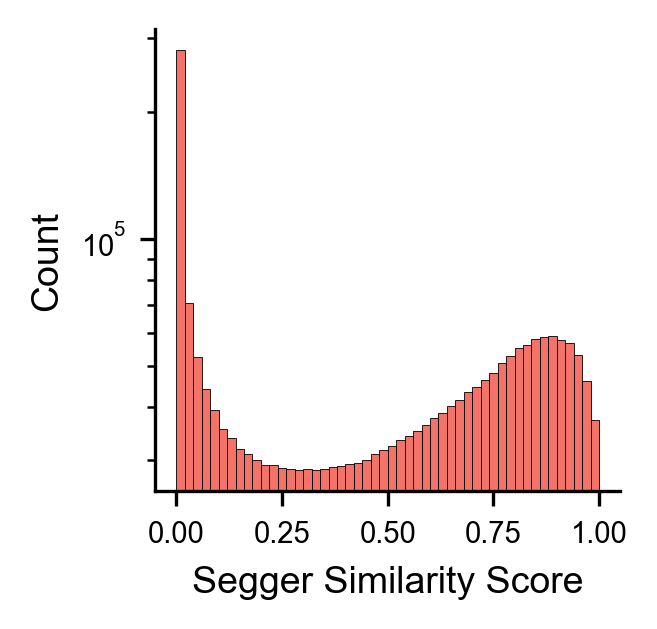

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(2,2))
sns.histplot(
    segmentation['score'],
    bins=50,
    ax=ax,
)
ax.set_ylabel('Count')
ax.set_xlabel('Segger Similarity Score')
ax.set_yscale('log')

#### The Importance of the Receptive Field in Segger

The **receptive field** is a critical parameter in Segger, as it directly influences how the model interprets the spatial relationships between **transcripts** and **nuclei**. In the context of spatial transcriptomics, the receptive field determines the size of the neighborhood that each node (representing transcripts or nuclei) can "see" during graph construction and model training. Segger is particularly sensitive to the size of the receptive field because it affects the model's ability to propagate information across the graph. If the receptive field is too small, the model may fail to capture sufficient context for correct cell boundary delineation. Conversely, a very large receptive field may introduce noise by linking unrelated or distant nodes, reducing segmentation accuracy.

#### Parameters affecting the receptive field in Segger:
- **`--r`**: This parameter defines the radius used when connecting transcripts to nuclei. A larger `r` expands the receptive field, linking more distant nodes. Fine-tuning this parameter helps ensure that Segger captures the right level of spatial interaction in the dataset.
- **`--k_bd` and `--k_tx`**: These control the number of nearest neighbors (nuclei and transcripts, respectively) considered in the graph. By increasing these values, the receptive field is effectively broadened, allowing more nodes to contribute to the information propagation.
- **`--dist_bd` and `--dist_tx`**: These parameters specify the maximum distances used to connect nuclei (`dist_bd`) and transcripts (`dist_tx`) to their neighbors during graph construction. They directly affect the receptive field by defining the cut-off distance for forming edges in the graph. Larger distance values expand the receptive field, connecting nodes that are further apart spatially. Careful tuning of these values is necessary to ensure that Segger captures relevant spatial relationships without introducing noise.

# **4. Tune Parameters**

### Evaluating Receptive Field Parameters with Grid Search

To evaluate the impact of different receptive field parameters in Segger, we use a **grid search** approach. The parameters `k_bd`, `k_tx`, `dist_bd`, and `dist_tx` (which control the number of neighbors and distances for nuclei and transcripts) are explored through various configurations defined in `param_space`. Each combination of these parameters is passed to the `trainable` function, which creates the dataset, trains the model, and makes predictions based on the specified receptive field.

For each parameter combination:
1. A dataset is created with the specified receptive field.
2. The Segger model is trained on this dataset.
3. Predictions are made, and segmentation results are evaluated using the custom `evaluate` function. This function computes metrics like the fraction of assigned transcripts and average cell sizes.

The results from each configuration are saved, allowing us to compare how different receptive field settings impact the model’s performance. This process enables a thorough search of the parameter space, optimizing the model for accurate segmentation.

In [ ]:
import itertools
import pandas as pd

In [ ]:
tuning_dir = Path('path/to/tutorial/tuning/')
sampling_rate = 0.125

In [ ]:
# Fixed function arguments used for each trial
transcripts_path = xenium_data_dir / 'transcripts.parquet'

boundaries_path = xenium_data_dir / 'nucleus_boundaries.parquet'

dataset_kwargs = dict(
    x_size=80, y_size=80, d_x=80, d_y=80, margin_x=10, margin_y=10,
    num_workers=4, sampling_rate=sampling_rate,
)

model_kwargs = dict(
    metadata=(['tx', 'bd'], [('tx', 'belongs', 'bd'), ('tx', 'neighbors', 'tx')]),
    num_tx_tokens=500, init_emb=8, hidden_channels=32, out_channels=8,
    heads=2, num_mid_layers=2, aggr='sum',
)

trainer_kwargs = dict(
    accelerator='cuda', strategy='auto', precision='16-mixed', devices=1,
    max_epochs=100,
)

predict_kwargs = dict(score_cut=0.2, use_cc=True)

In [ ]:
def trainable(config):

    receptive_field = {k: config[k] for k in ['k_bd', 'k_tx', 'dist_bd', 'dist_tx']}

    # Dataset creation
    xs = XeniumSample(verbose=False)
    xs.set_file_paths(transcripts_path, boundaries_path)
    xs.set_metadata()
    try:
        xs.save_dataset_for_segger(
            processed_dir=config['data_dir'],
            receptive_field=receptive_field,
            **dataset_kwargs,
        )
    except:
        pass

    # Model training
    ls = LitSegger(**model_kwargs)
    dm = SeggerDataModule(
        data_dir=config['data_dir'],
        batch_size=2,
        num_workers=dataset_kwargs['num_workers'],
    )
    trainer = Trainer(
        default_root_dir=config['model_dir'],
        logger=CSVLogger(config['model_dir']),
        **trainer_kwargs,
    )
    trainer.fit(model=ls, datamodule=dm)

    segmentation = predict(
        load_model(config['model_dir']/'lightning_logs/version_0/checkpoints'),
        dm.train_dataloader(),
        receptive_field=receptive_field,
        **predict_kwargs,
    )

    metrics = evaluate(segmentation)


def evaluate(segmentation: pd.DataFrame, score_cut: float) -> pd.Series:

    assigned = segmentation['score'] > score_cut
    metrics = pd.Series(dtype=float)
    metrics['frac_assigned'] = assigned.mean()
    cell_sizes = segmentation.groupby(assigned)['segger_cell_id'].value_counts()
    assigned_avg = 0 if True not in cell_sizes.index else cell_sizes[True].mean()
    cc_avg = 0 if False not in cell_sizes.index else cell_sizes[False].mean()
    metrics['cell_size_assigned'] = assigned_avg
    metrics['cell_size_cc'] = cc_avg
    return metrics

In [ ]:
param_space = {
    "k_bd": [3, 5, 10],
    "dist_bd": [5, 10, 15, 20],
    "k_tx": [3, 5, 10],
    "dist_tx": [3, 5, 10],
}

metrics = []

for params in itertools.product(*param_space.values()):

    config = dict(zip(param_space.keys(), params))

    # Setup directories
    trial_dir = tuning_dir / '_'.join([f'{k}={v}' for k, v in config.items()])

    data_dir = trial_dir / 'segger_data'
    data_dir.mkdir(exist_ok=True, parents=True)
    config['data_dir'] = data_dir

    model_dir = trial_dir / 'models'
    model_dir.mkdir(exist_ok=True, parents=True)
    config['model_dir'] = model_dir

    segmentation = trainable(config)
    trial = evaluate(segmentation, predict_kwargs['score_cut'])
    trial = pd.concat([pd.Series(config), trial])
    metrics.append(trial)

metrics = pd.DataFrame(metrics)

### Interpreting Output Metrics

The key output metrics include:
- **`frac_assigned`**: The fraction of transcripts that were successfully assigned to a cell. A higher value indicates that the model is doing a good job associating transcripts with nuclei, which is a strong indicator of successful segmentation.
- **`cell_size_assigned`**: The average size of cells that have assigned transcripts. This helps assess how well the model is predicting cell boundaries, with unusually large or small values indicating potential issues with segmentation accuracy.
- **`cell_size_cc`**: The average size of connected components that were not assigned to a cell (i.e., nucleus-less regions). Large values here may suggest that transcripts are being incorrectly grouped together in the absence of a nucleus, which could indicate problems with the receptive field parameters or the segmentation process.

These metrics illuminate the effectiveness of the model by highlighting both the success in associating transcripts with cells and potential areas where the model may need further tuning.


In [ ]:
metrics